In [11]:
# data processing
import numpy as np
import os
import sys
import pandas as pd
import pickle

# Machine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# Processing configuration
class Location:
    """Specify the locations of inputs and outputs"""

    # Get the path of the directory containing the script file
    script_dir = os.path.dirname(os.path.abspath(sys.path[0]))

    # Navigate up to the top-level directory
    src_level_dir = os.path.dirname(script_dir)

    top_level_dir = os.path.dirname(src_level_dir)

    # Define the relative path to the data directory
    data_dir = os.path.join(top_level_dir, "AutomatingAnalysisModelsAndMisprediction\\data")

    data_raw: str = f"{data_dir}\\raw\\company_bankruptcy.csv"
    data_process: str = f"{data_dir}\\processed\\company_bankruptcy.pkl"
    
    
class ProcessConfig:
    """Specify the parameters of the `process` flow"""

    label: str = "Bankrupt?"
    test_size: float = 0.2

In [13]:
# Processing functions
def getProcessedData(file_path: str):
    # read python dict back from the file
    with open(file_path, 'rb') as f:
        split_dict = pickle.load(f)

    X_train = split_dict["X_train"]
    X_test = split_dict["X_test"]
    y_train = split_dict["y_train"]
    y_test = split_dict["y_test"]
    return X_train, X_test, y_train, y_test

def getUnprocessedData(url: str):
    dataset = pd.read_csv(url)
    return dataset

In [14]:
# Get unprocessed data
dataset = getUnprocessedData(Location.data_raw)
dataset.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [15]:
# get the data
X_train, X_test, Y_train, Y_test = getProcessedData(Location.data_process)


In [16]:
# Standardize features. Require for Machine learning
sc = StandardScaler()
# Fit to data, then transform it
X_train = sc.fit_transform(X_train)
sc.mean_


array([4.63159006e-01, 5.09976597e-01, 5.08892388e-01, 6.03272263e-01,
       6.03286064e-01, 9.98721950e-01, 7.96963972e-01, 8.08849384e-01,
       3.03297849e-01, 7.81153461e-01, 1.89811490e+09, 1.70876580e+09,
       4.63859817e-01, 9.84339413e+06, 7.49259481e-02, 1.76095235e-01,
       1.76024012e-01, 1.76119460e-01, 2.09254920e-01, 3.19971772e-01,
       7.15097590e+05, 9.87452007e-02, 1.66686700e-01, 2.23603724e-02,
       8.47561174e-01, 6.87788289e-01, 6.87805166e-01, 2.17424628e-01,
       5.21339224e+09, 1.06691580e+07, 2.63834224e-01, 3.76630794e-01,
       2.60466009e+05, 1.20375208e+07, 6.30861255e-01, 6.56105094e+06,
       1.48653263e-01, 8.51346737e-01, 8.71628364e-03, 3.82568258e-01,
       7.17275206e-03, 9.87607463e-02, 1.65747333e-01, 4.05974382e-01,
       1.23485200e-01, 8.23363096e+06, 5.66552837e+06, 2.04603242e+09,
       1.40192239e+09, 4.02332960e-02, 9.33833203e+06, 3.92414956e-01,
       7.98408317e+06, 7.85052749e-01, 3.58870511e-01, 5.02656561e-01,
      

In [17]:
sc.scale_

array([7.72427259e-02, 9.17372582e-02, 8.27365192e-02, 1.58117092e-02,
       1.57898140e-02, 1.04552748e-02, 1.02555925e-02, 1.09205289e-02,
       8.83889455e-03, 1.02284348e-02, 3.16650651e+09, 2.42000820e+09,
       1.51261573e-02, 8.06494065e+07, 1.26077647e-01, 3.11023688e-02,
       3.12051390e-02, 3.12213582e-02, 3.59841675e-02, 1.52115344e-02,
       3.88742186e+07, 2.51287903e-02, 3.41513288e-02, 9.83644916e-03,
       9.57100907e-03, 1.38177819e-02, 1.38558387e-02, 8.24270206e-03,
       2.52605777e+09, 2.65203735e+08, 7.79030646e-03, 3.39440073e-02,
       2.67621683e+07, 2.77438425e+08, 1.28980215e-02, 1.60730254e+08,
       6.17379166e-02, 6.17379166e-02, 2.91695767e-02, 4.00428879e-02,
       2.69447604e-02, 2.48830938e-02, 3.20982283e-02, 2.60157070e-02,
       9.15138219e-02, 2.07481722e+08, 1.91328334e+08, 3.01085532e+09,
       2.73950268e+09, 3.51263263e-02, 2.08359722e+08, 2.80805037e-02,
       2.22481262e+08, 6.31139964e-02, 1.91893446e-01, 2.07389818e-01,
      

In [18]:
# Perform standardization by centering and scaling
X_test = sc.transform(X_test)
X_test

array([[-0.27818633, -0.2858347 , -0.26698037, ..., -0.05090025,
         0.        , -0.25079791],
       [ 0.07013299, -0.43140309, -0.10250544, ..., -0.26333267,
         0.        , -0.30748897],
       [ 3.26493184,  3.05853509,  3.19870953, ..., -0.01173989,
         0.        ,  0.0163597 ],
       ...,
       [ 0.62747355,  0.35534778,  0.55026503, ...,  0.13599367,
         0.        , -0.16385017],
       [-0.45719419, -0.25082362, -0.36332168, ..., -0.59202592,
         0.        , -0.42978155],
       [ 0.26142287,  0.42071393,  0.28237937, ...,  0.08906777,
         0.        , -0.32741006]])

In [19]:
# Init an H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,9 hours 43 mins
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_Administrator_71jcrd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.226 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [20]:
# Convert training data to H2OFrame
# the train result will be used to train a machine learning model
train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
train.columns = list(dataset.columns)

# Specify target variable and predictor variables
x = train.columns[:-1]
y = train.columns[-1]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
# Run H2O AutoML to automatically select, train and optimize SVM model
aml = H2OAutoML(max_models=10, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
22:44:27.266: AutoML: XGBoost is not available; skipping it.
22:44:27.274: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]
22:44:27.274: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
22:44:30.944: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]
22:44:30.944: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█████████████████████████████████████████
22:47:49.869: _train param, Dropping bad and constant columns: [ Interest Coverage Ratio (Interest expense to EBIT)]
22:47:49.869: _response param, We have detected that your res

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_1_AutoML_3_20230226_224427


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    401                401                         315201                 13           15           14.9825       16            86            57.5436

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0026086028134865895
RMSE: 0.05107448299774154
MAE: 0.032659803605297986
RMSLE: 0.042002276969698174
Mean Residual Deviance: 0.0026086028134865895

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.016174947953254977
RMSE: 0.12718076880273596
MAE: 0.07314456139153337
RMSLE: 0.09954621937459761
Mean Residual Deviance: 0.016174947953254977

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0731448  0.00222768   0.0693644     0.0737966     0.0732455     0.0741397     0.0751781
mean_residual_deviance  0.016175   0.000598078  0.01511       0.0164842     0.0163706     0.0164014     0.0165088
mse                     0.016175   0.000598078  0.01511       0.0164842     0.0163706     0.0164014     0.0165088
r2                      0.935214   0.00243559   0.939557      0.934017      0.934312      0.934328      0.933857
residual_deviance       0.016175   0.000598078  0.01511       0.0164842     0.0163706     0.0164014     0.0165088
rmse                    0.127163   0.00238087   0.122923      0.128391      0.127948      0.128068      0.128487
rmsle                   0.0995208  0.00252376   0.0956812     0.101851      0.0991657     0.0991412     0.101765

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse         training_mae          training_deviance
---  -------------------  ----------------  -----------------  --------------------  --------------------  ---------------------
     2023-02-26 22:47:02  2 min 31.351 sec  0.0                0.49999824169779716   0.49999648340178193   0.2499982417008888
     2023-02-26 22:47:02  2 min 31.763 sec  5.0                0.36091032642369414   0.3514118676503785    0.13025626371925747
     2023-02-26 22:47:03  2 min 32.273 sec  10.0               0.2861804742755044    0.25794890752444327   0.08189926385655263
     2023-02-26 22:47:03  2 min 32.827 sec  15.0               0.24744823085228412   0.1991403240535488    0.06123062695192529
     2023-02-26 22:47:04  2 min 33.294 sec  20.0               0.22407668556643878   0.16053600889872488   0.05021036101444067
     2023-02-26 22:47:04  2 min 33.756 sec  25.0               0.20691894302930453   0.13419492291835475   0.042815448984364575
     2023-02-26 22:47:05  2 min 34.269 sec  30.0               0.19182973413976445   0.11549668360807419   0.036798646900132716
     2023-02-26 22:47:05  2 min 34.701 sec  35.0               0.18121228681172202   0.10489852575215237   0.0328378928915338
     2023-02-26 22:47:06  2 min 35.168 sec  40.0               0.1726410565075538    0.09841076894323031   0.02980493439204438
     2023-02-26 22:47:06  2 min 35.667 sec  45.0               0.1653582749317089    0.0941941043442392    0.02734335908839063
---  ---                  ---               ---                ---                   ---                   ---
     2023-02-26 22:47:44  3 min 13.942 sec  360.0              0.05609214047873441   0.0355853951478983    0.0031463282234860755
     2023-02-26 22:47:45  3 min 14.422 sec  365.0              0.05529190336762342   0.03510965790974142   0.0030571

In [22]:
# View the leaderboard of trained models
lb = aml.leaderboard
print(lb.head())

model_id                               mse         rmse            mae        rmsle    mean_residual_deviance
GBM_1_AutoML_3_20230226_224427  0.0161749   0.127181         0.0731446    0.0995462                0.0161749
DRF_1_AutoML_3_20230226_224427  0.0279038   0.167044         0.0847636    0.121871                 0.0279038
GLM_1_AutoML_3_20230226_224427  6.3023e+12  2.51044e+06  24432.4        nan                        6.3023e+12
[3 rows x 6 columns]



In [23]:
# Use the best model to predict on test data
model = aml.leader
X_h2o = h2o.H2OFrame(X_test)
X_h2o.columns = list(dataset.columns)[:-1]
y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [24]:
# Train a PySVM SVM model
model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
Y_pred = model.fit(X_train, Y_train)

In [25]:
# fig, ax = plt.subplots(figsize=(8,5))
# sns.scatterplot(Y_pred, y[ProcessConfig.label] ,ax=ax)
# sns.lineplot(Y_pred,Y_pred,ax=ax,color='black')
# ax.set_xlabel(ProcessConfig.label)

In [26]:
# Test the model on the test data
y_pred = model.predict(X_test)
misclassified = np.where(Y_test != y_pred)[0]
print("Indices of potentially misclassified instances: ", misclassified)

Indices of potentially misclassified instances:  [   0   12   16   22   55   61   64   71   88   89   94  109  110  121
  122  124  129  145  149  157  159  176  184  187  204  221  237  269
  279  284  313  318  347  349  381  388  391  395  405  417  451  453
  459  465  468  477  523  544  550  552  553  559  563  581  582  584
  590  593  601  609  621  627  639  651  657  677  689  690  698  707
  708  721  734  750  755  767  789  808  821  833  844  861  867  873
  883  942  971  972  979  988  993  994  998  999 1018 1047 1076 1077
 1085 1117 1143 1157 1168 1173 1189 1196 1197 1207 1210 1214 1219 1224
 1229 1242 1245 1248 1254 1258 1272 1273 1283 1292 1312 1329 1342 1345
 1359 1374 1393 1407 1411 1423 1431 1446 1448 1486 1496 1502 1507 1508
 1520 1530 1544 1546 1553 1555 1585 1591 1599 1612 1624 1628 1636 1637
 1651 1656 1657 1660 1670 1690 1695 1718 1726 1741 1745 1754 1761 1770
 1771 1781 1782 1801 1803 1809 1827 1835 1874 1905 1944 1967 1968 1971
 1974 1979 1998 2007 2011 20

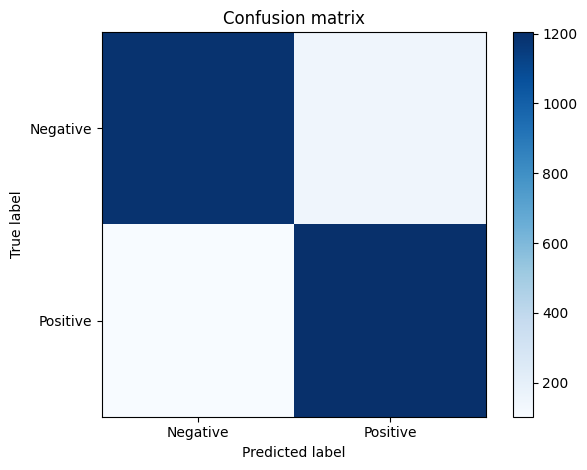

In [27]:
# Confusion matrix - summarizing the performance of a classification algorithm.
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.tight_layout()
plt.show()

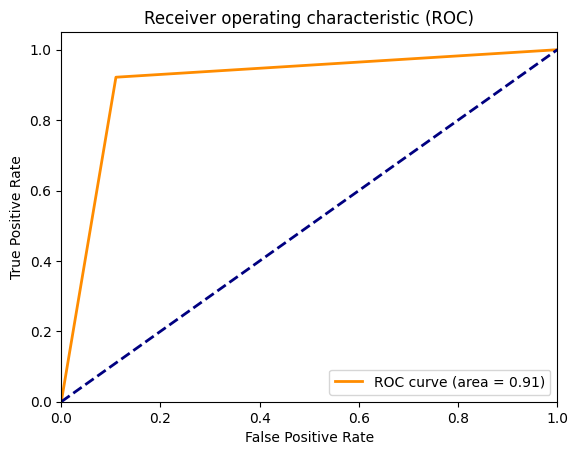

In [28]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()